In [74]:
import os
import pandas as pd
import numpy as np


In [75]:
clusters = pd.read_csv('/home/skutukov/datasets/temp/res.txt', sep='\t', header=None)
clusters.columns = ['user', 'cluster_id']


In [76]:
print(clusters.head())


   user  cluster_id
0     0         307
1     1         307
2     2         307
3     3         307
4     4           0


# Size of biggest cluster

In [77]:
print("biggest 20 clusters")
print(clusters.cluster_id.value_counts().head(20))
print(clusters.cluster_id.value_counts().values)


biggest 20 clusters
307     14731
220      8976
505      3563
1149     2381
459      2329
440      1979
527      1218
615       639
1430      526
854       453
207       433
2186      432
1431      426
2215      404
2089      381
2196      377
3         345
2169      318
1079      318
2255      309
Name: cluster_id, dtype: int64
[14731  8976  3563 ...     1     1     1]


# Bar chart for visualizing difference in cluster sizes of 100 biggest clusters


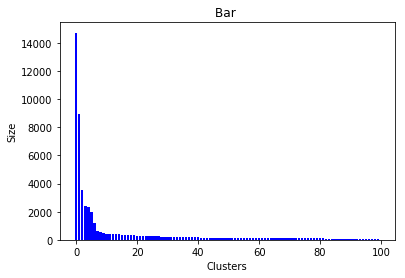

In [78]:
import matplotlib.pyplot as plt
X = clusters.cluster_id.value_counts().head(100).values
def plot_bar_x(X):
    # this is for plotting purpose
    index = range(len(X))
    plt.bar(x=index, height=X, color="blue")
    plt.xlabel('Clusters')
    plt.ylabel('Size')
    plt.title('Bar ')
    plt.show()

plot_bar_x(X) 


In [79]:
# Histograms of clusters sizes with log scaled counts

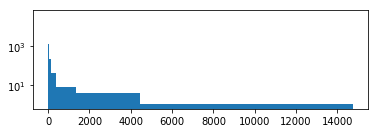

In [80]:
X = clusters.cluster_id.value_counts().values
bins = [10, 100, 200, 300, 400, 500, 1000, 2000, 14731]
def plot_bar_x(X, bins):
    # this is for plotting purpose
    x = pd.Series(X)

    hist, bins, _ = plt.hist(x, bins=8)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.yscale('log')
    plt.show()

plot_bar_x(X, bins) 


In [81]:
print("Number of clusters: ", X.shape[0])
print("Number of clusters with size 1: ", X[X<=1].shape[0])
print("Number of clusters with size more than 1: ", X[X>1].shape[0])

Number of clusters:  54639
Number of clusters with size 1:  29184
Number of clusters with size more than 1:  25455


# Read checkins

In [33]:
import pandas as pd

checkins_file = "/home/skutukov/datasets/temp/Gowalla_totalCheckins.txt"
checkins = pd.read_csv(checkins_file, sep='\t', header=None)
checkins = checkins.drop(checkins.columns[[1, 2, 3]], axis=1)
checkins.columns = ['user', 'location_id']
print(checkins.head())

   user  location_id
0     0        22847
1     0       420315
2     0       316637
3     0        16516
4     0      5535878


In [34]:
# print(clusters.head())
checkins = checkins.merge(clusters, left_on='user', right_on='user',
                          how='inner')
print(checkins.head())


   user  location_id  cluster_id
0     0        22847         307
1     0       420315         307
2     0       316637         307
3     0        16516         307
4     0      5535878         307


# Calculate top locations


In [35]:

count = 10
def get_top(x):
    top = x.location_id.value_counts().head(count).index.values
    return pd.Series(top)

top_checkins = checkins.groupby('cluster_id').apply(get_top).unstack()


In [36]:
print(top_checkins.shape)
print(top_checkins.head())
top_checkins.shape[0]

(34117, 10)
                   0         1          2         3         4         5  \
cluster_id                                                                
0             9191.0   24650.0    24894.0    8964.0  420315.0  153505.0   
1             9961.0  691005.0  1200646.0  894754.0   26995.0  530972.0   
2           420315.0   17208.0     9371.0   21714.0  887540.0   72530.0   
3            91717.0  703421.0   869843.0  689974.0  124660.0   56902.0   
4           211348.0  102499.0    57155.0  188615.0   53896.0  225674.0   

                    6          7          8         9  
cluster_id                                             
0             21714.0    57155.0   113848.0   19542.0  
1            156695.0  1357197.0  1164333.0   95179.0  
2             16233.0    28221.0   575801.0  755297.0  
3           1250475.0   443999.0  1130695.0  127460.0  
4             40971.0    21194.0   203431.0  152880.0  


34117

In [37]:
test_user_top_chekings = checkins.merge(top_checkins, left_on='cluster_id',
                                             right_on='cluster_id', how='inner')
print(test_user_top_chekings.head())

   user  location_id  cluster_id        0       1       2        3        4  \
0     0        22847         307  19542.0  9410.0  9246.0  10190.0  14470.0   
1     0       420315         307  19542.0  9410.0  9246.0  10190.0  14470.0   
2     0       316637         307  19542.0  9410.0  9246.0  10190.0  14470.0   
3     0        16516         307  19542.0  9410.0  9246.0  10190.0  14470.0   
4     0      5535878         307  19542.0  9410.0  9246.0  10190.0  14470.0   

         5        6        7       8        9  
0  10259.0  55033.0  23256.0  9241.0  22831.0  
1  10259.0  55033.0  23256.0  9241.0  22831.0  
2  10259.0  55033.0  23256.0  9241.0  22831.0  
3  10259.0  55033.0  23256.0  9241.0  22831.0  
4  10259.0  55033.0  23256.0  9241.0  22831.0  


In [38]:
print(test_user_top_chekings.shape[0])

6442892


In [39]:
uniq_clusters = test_user_top_chekings.cluster_id.unique()


In [40]:
clusters_count = {}
clusters_match = {}

for index, row in test_user_top_chekings.iterrows():
    if index % 500000 == 0:
        print(index/test_user_top_chekings.shape[0])
        
    if row.cluster_id in clusters_count:
        clusters_count[row.cluster_id] += 1
    else:
        clusters_count[row.cluster_id] = 1
    location = 0
    isMatch = False
    for i in range(0, 10):
        if row['location_id'] == row[i]:
            isMatch = True
            break
    if isMatch:
        if row.cluster_id in clusters_match:
              clusters_match[row.cluster_id] += 1
        else:
              clusters_match[row.cluster_id] = 1



0.0


0.07760490164975604


0.1552098032995121


0.23281470494926812


0.3104196065990242


0.3880245082487802


0.46562940989853624


0.5432343115482923


0.6208392131980484


0.6984441148478043


0.7760490164975604


0.8536539181473165


0.9312588197970725


## Calculate accuracy for each cluster 

In [41]:

rank = np.zeros_like(uniq_clusters, dtype=float)
for i, u in enumerate(uniq_clusters):
    if u in clusters_match:
        rank[i] = clusters_match[u]/clusters_count[u]
        # print(u, clusters_match[u], clusters_count[u], clusters_match[u]/clusters_count[u],  rank[i])
    else: 
        rank[i] = 0
        # print(rank[i])


##  Mean accuracy of all clusters 


In [42]:

print('mean score', rank.sum()/clusters.shape[0])


mean score 0.11941666004944665


##  Mean accuracy of clusters with positive scores 



In [43]:
print('mean non-zero score ', rank[rank != 0].mean())


mean non-zero score  0.6881097580613995
